# Introdução
## Objetivo:
Treinar uma rede neural BERT no Keras para detectar bots no Twitter utilizando o dataset Twitter-Bot Detection, disponível no Kaggle.

## Links de apoio:
- [Repositório do Github](https://github.com/VitorMoura01/Twitter-Bot-Bert)
- [Dataset Kaggle](https://www.kaggle.com/datasets/goyaladi/twitter-bot-detection-dataset/data)

*Vitor Moura - T4G1*

# Preparação do ambiente 🏡

## Imports

In [1]:
%load_ext cudf.pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pandas as pd
import dask.dataframe as dd
from dask import delayed, compute
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Lambda
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
import re
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel, BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

## Leitura

In [5]:
df = pd.read_csv('/content/bot_detection_data.csv')

# Análise exploratória 🔍

In [6]:
df.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,None
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [7]:
df.columns

Index(['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count',
       'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At',
       'Hashtags'],
      dtype='object')

In [8]:
df.shape

(50000, 11)

In [9]:
df['Bot Label'].value_counts()

,count
Bot Label,
1,25018
0,24982


<Axes: xlabel='Bot Label'>

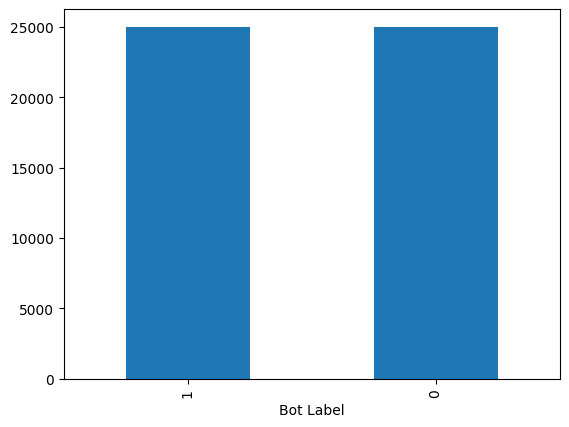

In [10]:
df['Bot Label'].value_counts().plot(kind='bar')

In [11]:
print(df.isnull().sum())
print(df.describe())

User ID              0
Username             0
Tweet                0
Retweet Count        0
Mention Count        0
Follower Count       0
Verified             0
Bot Label            0
Location             0
Created At           0
Hashtags          8341
dtype: int64
             User ID  Retweet Count  Mention Count  Follower Count  \
count   50000.000000    50000.00000   50000.000000    50000.000000   
mean   548890.680540       50.00560       2.513760     4988.602380   
std    259756.681425       29.18116       1.708563     2878.742898   
min    100025.000000        0.00000       0.000000        0.000000   
25%    323524.250000       25.00000       1.000000     2487.750000   
50%    548147.000000       50.00000       3.000000     4991.500000   
75%    772983.000000       75.00000       4.000000     7471.000000   
max    999995.000000      100.00000       5.000000    10000.000000   

          Bot Label  
count  50000.000000  
mean       0.500360  
std        0.500005  
min        0.00

In [12]:
correlation_matrix = df[['Retweet Count', 'Mention Count', 'Follower Count', 'Bot Label']].corr()

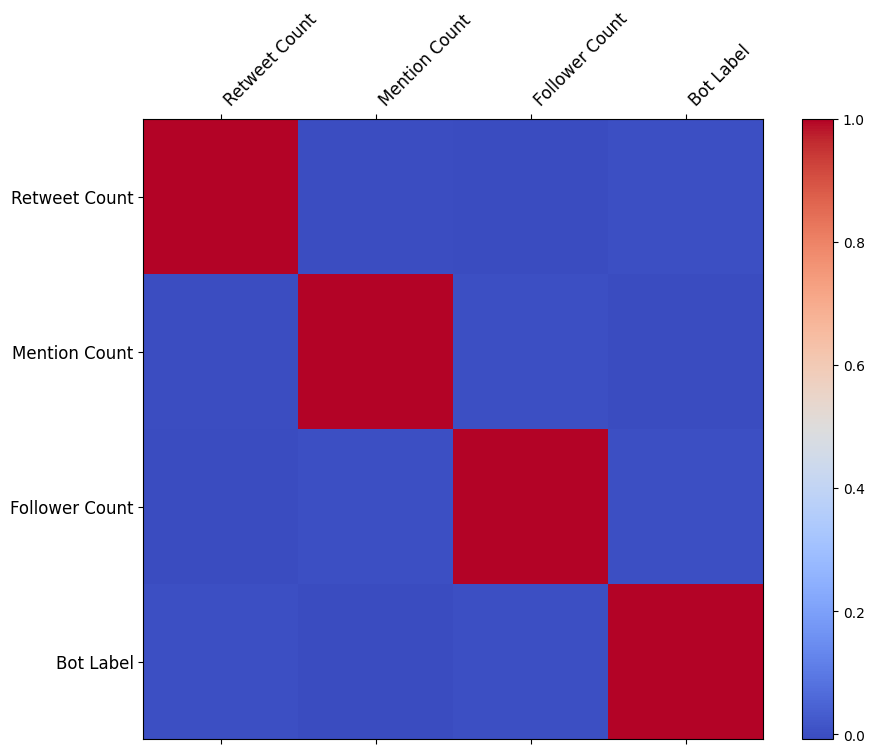

In [13]:
# Adjusting the figure size for better spacing
plt.figure(figsize=(10, 8))

# Plot the correlation matrix
plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')

# Add color bar to show correlation scale
plt.colorbar()

# Set ticks and labels with spacing adjustments
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='left', fontsize=12)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=12)

# Add space at the bottom for x-axis labels
plt.gcf().subplots_adjust(bottom=0.25)

# Display the plot
plt.show()

Podemos observar que variáveis numéricas não sao bons preditores isolados para a classificação. O conteúdo textual dos tweets e outras features provavelmente são mais relevantes.

# Tratamento dos dados

In [14]:
df.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,None
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [15]:
df['Verified'] = df['Verified'].astype('int')

In [16]:
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [17]:
# Função para tokenizar o texto usando o BERT tokenizer
def tokenize_text(texts, max_length=128):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = tokenizer(
        texts,  # Converter textos em lista
        max_length=max_length,  # Limite de tamanho dos tokens
        padding='max_length',  # Preencher com zeros até o tamanho máximo
        truncation=True,  # Truncar tokens maiores que o limite
        return_tensors='pt'  # Retornar tensores prontos para PyTorch
    )
    return tokens

In [18]:
sample_data = {
    'Tweet': [
        "Station activity person against natural majority none few size expect six marriage.",
        "Authority research natural life material staff rate common protect attention.",
        "Manage whose quickly especially foot none to goal range case.",
        "Just cover eight opportunity strong policy which.",
        "Animal sign six data good or."
    ]
}

# Aplicar pré-processamento nos tweets
sample_data['Cleaned Tweet'] = [preprocess_text(tweet) for tweet in sample_data['Tweet']]

# Tokenizar os tweets
tokens = tokenize_text(sample_data['Cleaned Tweet'])

tokens

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'input_ids': tensor([[ 101, 2276, 4023, 2711, 2114, 3019, 3484, 3904, 2261, 2946, 5987, 2416,
         3510,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 3691, 2470, 3019, 2166, 3430, 3095, 3446, 2691, 4047, 3086,  102,
            0,    0,    0,    0,    0

# BERT

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Tokenização

In [20]:
# Função para tokenizar os dados de entrada
def tokenize_data(texts, max_length=128):
    tokens = tokenizer(
        texts.to_list(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return tokens['input_ids'], tokens['attention_mask']

tweets = df['Tweet']
labels = df['Bot Label']

input_ids, attention_masks = tokenize_data(tweets)

In [21]:
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()

## Treino e teste

In [22]:
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids_np, attention_masks_np, labels, test_size=0.2, random_state=42
)

In [23]:
X_train_ids = tf.convert_to_tensor(X_train_ids)
X_test_ids = tf.convert_to_tensor(X_test_ids)
X_train_masks = tf.convert_to_tensor(X_train_masks)
X_test_masks = tf.convert_to_tensor(X_test_masks)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

## Modelo

In [24]:
input_ids_layer = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Definir uma função Lambda para chamar o BERT
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    output = bert_model(input_ids, attention_mask=attention_mask)
    return output.last_hidden_state

# Usar Lambda com output_shape explícito
bert_output = Lambda(bert_layer, output_shape=(128, 768))([input_ids_layer, attention_mask_layer])

# Usamos a saída da última camada oculta de BERT (token [CLS])
cls_token = bert_output[:, 0, :]  # Pegar o token [CLS]

dropout = Dropout(0.3)(cls_token)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

model.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(
    [X_train_ids, X_train_masks], y_train,
    validation_data=([X_test_ids, X_test_masks], y_test),
    epochs=10,
    batch_size=8
)

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 344s 69ms/step - accuracy: 0.5023 - loss: 0.7188 - val_accuracy: 0.4931 - val_loss: 0.6995
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 337s 67ms/step - accuracy: 0.4912 - loss: 0.7177 - val_accuracy: 0.4898 - val_loss: 0.6984
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 337s 67ms/step - accuracy: 0.4955 - loss: 0.7123 - val_accuracy: 0.4952 - val_loss: 0.6971
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 337s 67ms/step - accuracy: 0.5009 - loss: 0.7090 - val_accuracy: 0.4929 - val_loss: 0.6968
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 337s 67ms/step - accuracy: 0.4967 - loss: 0.7077 - val_accuracy: 0.4929 - val_loss: 0.6964
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 337s 67ms/step - accuracy: 0.5025 - loss: 0.7049 - val_accuracy: 0.4942 - val_loss: 0.6958
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 338s 68ms/step - accuracy: 0.5027 - loss: 0.7022 - val_accuracy: 0.4931 - val_loss: 0.6960
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 338s 68ms/step - accuracy: 

In [27]:
loss, accuracy = model.evaluate([X_test_ids, X_test_masks], y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.5019 - loss: 0.6939
Loss: 0.6949418187141418, Accuracy: 0.4966000020503998


313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step


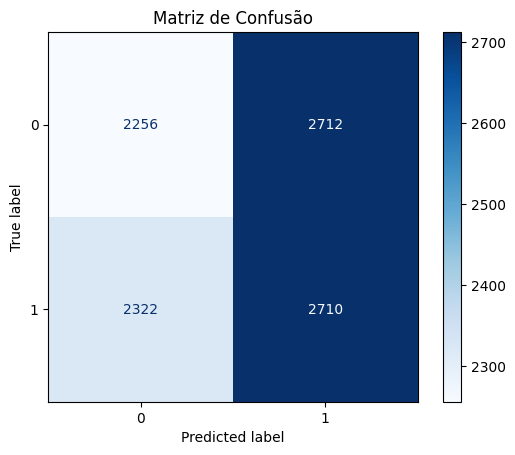

In [29]:
y_pred_probs = model.predict([X_test_ids, X_test_masks])
y_pred = (y_pred_probs > 0.5).astype(int)

# MATRIZ DE CONFUSÃO
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

F 👎

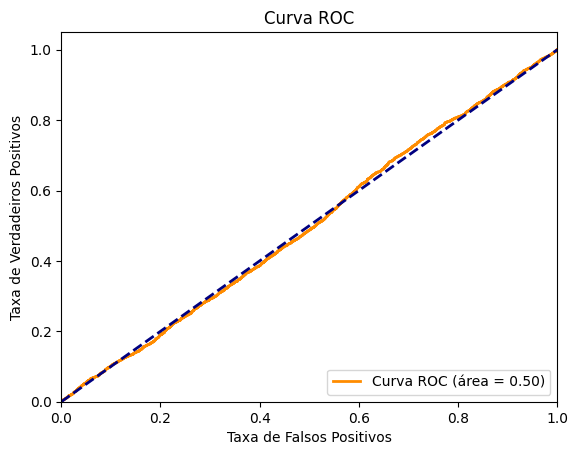

In [30]:
# CURVA ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()